<a href="https://colab.research.google.com/github/ricardocarreras/Bootcamp_DataScience_student/blob/master/Copia_de_ParisTweetSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tiny-tokenizer flair

In [ ]:
from flair.data import Sentence
from flair.models import SequenceTagger
tagger = SequenceTagger.load('ner')
import sys, os, re, tweepy
from tweepy import OAuthHandler
from textblob import TextBlob
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from flair.models import TextClassifier
classifier = TextClassifier.load('en-sentiment')

In [ ]:
#enter twitter API credentials here in the quotes
consumer_key = ''
consumer_secret = ''
access_key= ''
access_secret = ''


In [ ]:
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth, wait_on_rate_limit=True,
				   wait_on_rate_limit_notify=True)
if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

In [ ]:
searchQuery = str(input('Enter keyword to get tweets: '))
maxTweets = 500 
Filter_Retweets = True 
tweetsPerQry = 100  
tweet_lst = []
if Filter_Retweets:
  searchQuery = searchQuery + ' -filter:retweets' 
sinceId = None
max_id = -10000000000
tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))
while tweetCount < maxTweets:
    try:
        if (max_id <= 0):
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry, lang="fr")
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="fr", since_id=sinceId)
        else:
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="fr", max_id=str(max_id - 1))
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="fr", max_id=str(max_id - 1),
                                        since_id=sinceId)
        if not new_tweets:
            print("No more tweets found")
            break
        for tweet in new_tweets:
          if hasattr(tweet, 'reply_count'):
            reply_count = tweet.reply_count
          else:
            reply_count = 0
          if hasattr(tweet, 'retweeted'):
            retweeted = tweet.retweeted
          else:
            retweeted = "NA"
          topic = searchQuery[:searchQuery.find('-')].capitalize().strip()
          tweetDate = tweet.created_at.date()
          tweet_lst.append([tweetDate, topic, 
                      tweet.id, tweet.user.screen_name, tweet.user.name, tweet.text, tweet.favorite_count, 
                      reply_count, tweet.retweet_count, retweeted])
        tweetCount += len(new_tweets)
        print("Downloaded {0} tweets".format(tweetCount))
        max_id = new_tweets[-1].id
    except tweepy.TweepError as e:
        print("some error : " + str(e))
        break
clear_output()
print("Downloaded {0} tweets".format(tweetCount))

Downloaded 500 tweets


In [ ]:
pd.set_option('display.max_colwidth', -1)
tweet_df = pd.DataFrame(tweet_lst, columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet', 'like_count', 'reply_count', 'retweet_count', 'retweeted'])
tweet_df.to_csv('tweets.csv')
tweet_df.head()

,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted
0,2020-01-18,Paris,1218538116287430656,abeille971,Misskipik💚💛❤🐝,Sinon a part ça tout va bien chez les FDO 🤔\n\nhttps://t.co/K8u0JkNw12,0,0,0,False
1,2020-01-18,Paris,1218538096678932480,maybbeen,Maybeq,jesper ya des truc a faire sur paris en fevrier...,0,0,0,False
2,2020-01-18,Paris,1218538086059204610,SadDolphins_Fan,Sad Dolphins Fan,"@4ngi3tr Paris, tu me manques 😔 https://t.co/Bk4g86Hckq",0,0,0,False
3,2020-01-18,Paris,1218538072981327874,ElAdil95,~ Neutralizaaad ~,"@YvanNaylors Mddr la compilation est nrv, sah c’est un joueur qui étai bon à Monaco après a Paris il s’est perdu c dommage",0,0,0,False
4,2020-01-18,Paris,1218538056233422849,BenoitBerthe,Benoît Berthé,Réforme des retraites : l’Unsa-RATP appelle à suspendre dès lundi la grève illimitée - via @Le_Parisien https://t.co/opHZkr1DWt,0,0,1,False


In [ ]:
nerlst = []
for index, row in tqdm(tweet_df.iterrows(), total=tweet_df.shape[0]):
  cleanedTweet = row['tweet'].replace("#", "")
  sentence = Sentence(cleanedTweet, use_tokenizer=True)
  tagger.predict(sentence)
  ners = sentence.to_dict(tag_type='ner')['entities']
  classifier.predict(sentence)
  label = sentence.labels[0]
  response = {'result': label.value, 'polarity':label.score}
  hashtags = re.findall(r'#\w+', row['tweet'])
  if len(hashtags) >= 1:
    for hashtag in hashtags:
      ners.append({ 'type': 'Hashtag', 'text': hashtag })
  for ner in ners:
    adj_polarity = response['polarity']
    if response['result'] == 'NEGATIVE':
      adj_polarity = response['polarity'] * -1
    nerlst.append([ row['tweet_dt'], row['topic'], row['id'], row['username'], 
                   row['name'], row['tweet'], ner['type'], ner['text'], response['result'], 
                   response['polarity'], adj_polarity, row['like_count'], row['reply_count'], 
                  row['retweet_count'] ])

100%|██████████| 500/500 [25:19<00:00,  2.43s/it]


In [ ]:
df_ner = pd.DataFrame(nerlst, columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet', 'tag_type', 'tag', 'sentiment', 'polarity', 
                                       'adj_polarity','like_count', 'reply_count', 'retweet_count'])
df_ner.head()
banned_words = ['Paris', 'paris', '#Paris', '#paris', 'Ile de France', 'PARIS', 'ILE DE FRANCE',
                'paris', 'Paris, France', 'Paris, FR','Paris France', 'Paris Ile de France', 
               '#PARIS', '#IDF', 'France','#France','FRANCE','#FRANCE', 'French','FRENCH','#French','#FRENCH','London','#London','LONDON','#LONDON','USA','NYC','NY','#NY','#NYC','TOKYO','#Tokyo','CHICAGO','Chicago','#Chicaco','UK','#UK','DUBAI']

df_ner = df_ner[~df_ner['tag'].isin(banned_words)]

In [ ]:
ner_groups = df_ner.groupby(['tag', 'tag_type']).agg({'tag': "count", 'adj_polarity': "mean",
                                                     'like_count': 'sum', 'reply_count': 'sum',
                                                     'retweet_count': 'sum'})
ner_groups = ner_groups.rename(columns={
    "tag": "Frequency",
    "adj_polarity": "Avg_Polarity",
    "like_count": "Total_Likes",
    "reply_count": "Total_Replies",
    "retweet_count": "Total_Retweets"
})
ner_groups = ner_groups.sort_values(['Frequency'], ascending=False)
ner_groups = ner_groups.reset_index()
ner_groups.head()

,tag,tag_type,Frequency,Avg_Polarity,Total_Likes,Total_Replies,Total_Retweets
0,#GiletsJaunes,Hashtag,20,-0.969213,176,0,159
1,#Acte62,Hashtag,14,-0.960568,283,0,255
2,de Paris,PER,8,-0.541760,3,0,0
3,#acte62,Hashtag,6,-0.993899,25,0,33
4,MaisonObjet de janvier,ORG,5,0.491751,0,0,0


In [ ]:
ner_groups['Sentiment'] = np.where(ner_groups['Avg_Polarity']>=0, 'POSITIVE', 'NEGATIVE')
ner_groups.head()

,tag,tag_type,Frequency,Avg_Polarity,Total_Likes,Total_Replies,Total_Retweets,Sentiment
0,#GiletsJaunes,Hashtag,20,-0.969213,176,0,159,NEGATIVE
1,#Acte62,Hashtag,14,-0.960568,283,0,255,NEGATIVE
2,de Paris,PER,8,-0.541760,3,0,0,NEGATIVE
3,#acte62,Hashtag,6,-0.993899,25,0,33,NEGATIVE
4,MaisonObjet de janvier,ORG,5,0.491751,0,0,0,POSITIVE


--2020-01-18 14:49:33--  http://clipart-library.com/data_images/149059.png
Resolving clipart-library.com (clipart-library.com)... 148.251.41.80
Connecting to clipart-library.com (clipart-library.com)|148.251.41.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20605 (20K) [image/png]
Saving to: ‘paris.png’

paris.png           100%[===================>]  20.12K  --.-KB/s    in 0.01s   

2020-01-18 14:49:34 (1.67 MB/s) - ‘paris.png’ saved [20605/20605]



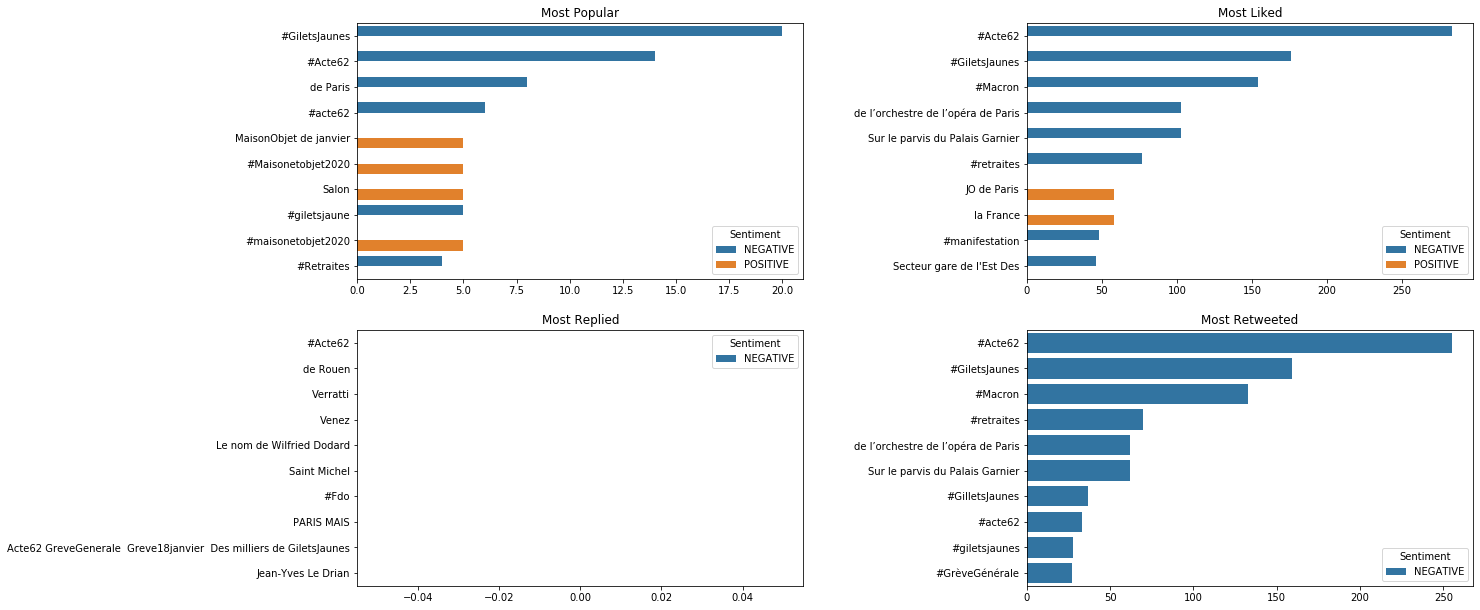

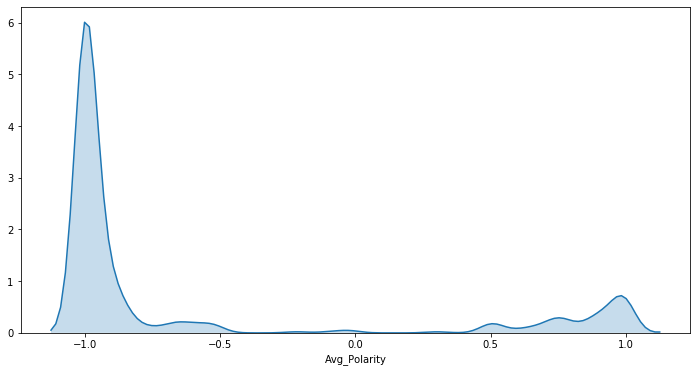

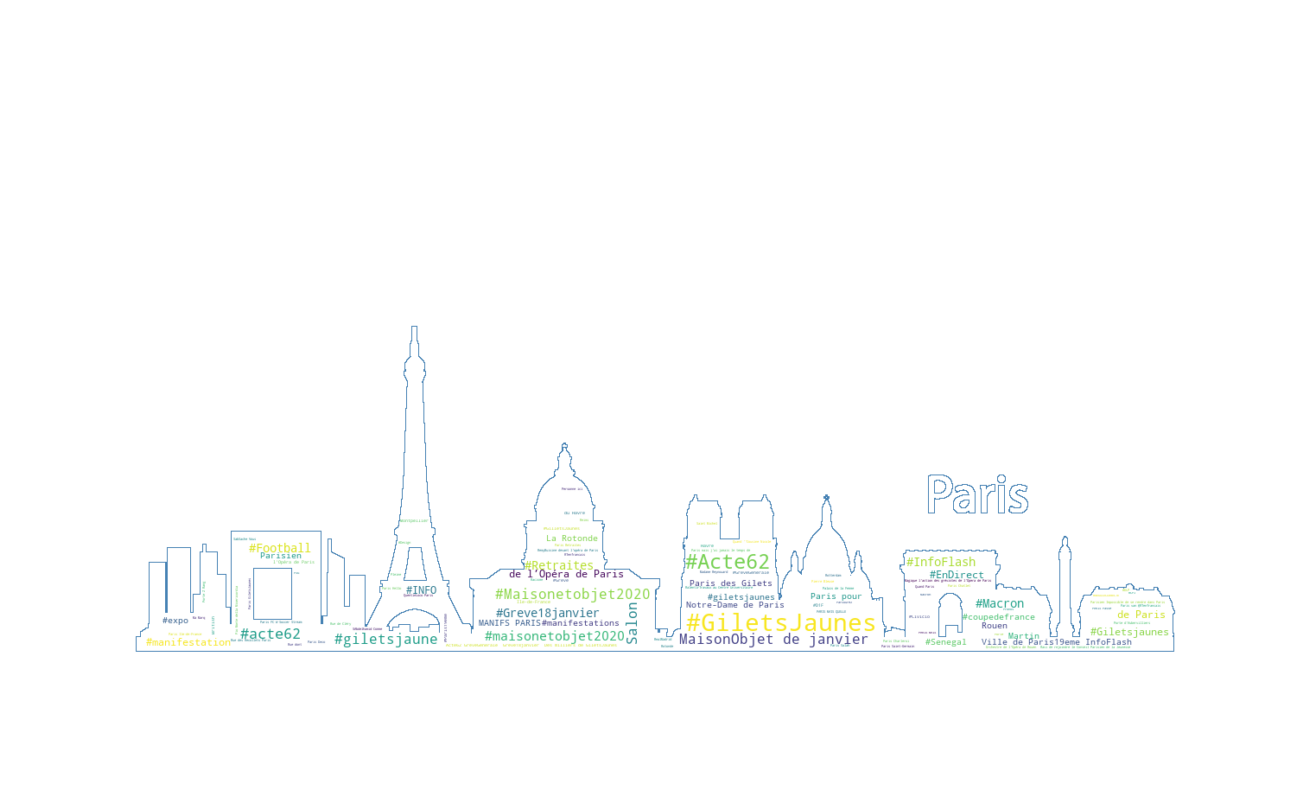

In [ ]:
Filter_TAG = False 
TAG = 'Hashtag' 
Top_N = 10 
if TAG != 'Hashtag':
  TAG = TAG[:3].upper()
if Filter_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups
# plot 
fig = plt.figure(figsize=(20, 16))
fig.subplots_adjust(hspace=0.2, wspace=0.5)
ax1 = fig.add_subplot(321)
sns.barplot(x="Frequency", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax2 = fig.add_subplot(322)
filtered_group = filtered_group.sort_values(['Total_Likes'], ascending=False)
sns.barplot(x="Total_Likes", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax3 = fig.add_subplot(323)
filtered_group = filtered_group.sort_values(['Total_Replies'], ascending=False)
sns.barplot(x="Total_Replies", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax4 = fig.add_subplot(324)
filtered_group = filtered_group.sort_values(['Total_Retweets'], ascending=False)
sns.barplot(x="Total_Retweets", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax1.title.set_text('Most Popular')
ax2.title.set_text('Most Liked')
ax3.title.set_text('Most Replied')
ax4.title.set_text('Most Retweeted')
ax1.set_ylabel('')    
ax1.set_xlabel('')
ax2.set_ylabel('')    
ax2.set_xlabel('')
ax3.set_ylabel('')    
ax3.set_xlabel('')
ax4.set_ylabel('')    
ax4.set_xlabel('')
fig = plt.figure(figsize=(12, 6))
sns.distplot(filtered_group['Avg_Polarity'], hist=False, kde_kws={"shade": True})
!wget http://clipart-library.com/data_images/149059.png -O paris.png
Metric = 'Frequency' 
Filter_TAG = False 
TAG = 'Hashtag' 
Mask = np.array(Image.open("paris.png"))
TAG = TAG[:3].upper()
if Filter_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups
countDict = {}
for index, row in filtered_group.iterrows():
  if row[Metric] == 0:
    row[Metric] = 1
  countDict.update( {row['tag'] : row[Metric]} )
wordcloud = WordCloud(
    max_words=100,
    height=300,
    width=800,
    background_color = 'white',
    mask=Mask,
    contour_width=1,
    contour_color='steelblue',
    stopwords = STOPWORDS).generate_from_frequencies(countDict)
fig = plt.figure(
    figsize = (18, 18),
    )
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()